In [1]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from data_preprocessing import data_preprocess
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
pd.set_option('display.max_colwidth', None)
from sympy import sympify
import seaborn as sns
import os
import warnings
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams.update({
    'font.size': 14,           # Global font size for all text
    'font.family': 'DejaVu Sans', # Global font family
    'font.sans-serif': ['DejaVu Sans'],  # Preferred sans-serif font
    'axes.titlesize': 16,      # Font size for titles
    'axes.labelsize': 14,      # Font size for axis labels
    'xtick.labelsize': 12,     # Font size for x-axis tick labels
    'ytick.labelsize': 12,     # Font size for y-axis tick labels
    'legend.fontsize': 12,     # Font size for legends
    'figure.titlesize': 16,    # Font size for figure title
})

In [3]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    return mse

def error_percentage(y, y_pred):
    index = np.where(y == 0)
    y = np.delete(y, index)
    y_pred = np.delete(y_pred, index)
    percentage = np.abs((y - y_pred) / y) * 100
    percentage = percentage[percentage != np.inf]
    error = np.mean(percentage)
    return error

def adjusted_r2(y, y_pred, p):
    r2 = r2_score(y, y_pred)
    n = len(y)
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adjusted_r2

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers

'''def y_calculation(model, origin_data):
    equation = model.sympy()
    # symbols is the column names of the origin data, except the target column:delta_phi
    symbols = sp.symbols(origin_data.columns[:-1])
    equation_func = sp.lambdify(symbols, equation, "numpy")
    y = equation_func(*[origin_data[col] for col in origin_data.columns[:-1]])
    return y, equation'''
    
import sympy as sp
import numpy as np

def y_calculation(model, origin_data):
    equation = model.sympy()
    column_names = origin_data.columns[:-1]
    symbols = sp.symbols(column_names)
    if 'density' in origin_data.columns:
        density = sp.Symbol('density')  # Create a symbol for 'density'
    else:
        raise ValueError("Density column is missing in the input data.")
    density_term = density / (10**(-16) + density**1.005)
    modified_equation = equation * density_term
    equation_func = sp.lambdify(symbols, modified_equation, "numpy")
    inputs = [origin_data[col].values for col in column_names]
    y = equation_func(*inputs)
    return y, modified_equation


def regression_plot(y_origin, y_pred):
    plt.scatter(y_origin, y_pred, color='#955251')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    r2 = r2_score(y_origin, y_pred)
    MAPE = error_percentage(y_origin, y_pred)
    plt.text(0.1, 0.9, f'$R^2$ = {r2:.3f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'MAPE = {MAPE:.3f}%', transform=plt.gca().transAxes)
    plt.ylim(-2,3)
    plt.plot(y_origin, y_origin, color='slategray', linestyle='--')
    
def plot_predict(model, data):
    X = data.drop('delta_phi', axis=1)
    y = model.predict(X)
    #y, equation = y_calculation(model, data)
    plt.figure(figsize=(13, 14))
    plt.subplot(4, 3, 1)
    regression_plot(data['delta_phi'], y)

    plt.subplot(4, 3, 2)
    ymax = max(y.max(), data['delta_phi'].max()) + 0.05
    ymin = min(y.min(), data['delta_phi'].min()) - 0.05
    scatter = plt.scatter(data['density'], data['delta_phi'], c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('True $\\Delta \\phi$')

    plt.subplot(4, 3, 3)
    scatter = plt.scatter(data['density'], y, c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    color_bar.set_label('Temperature')
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('Predicted $\\Delta \\phi$')

    unique_mw = data['nu'].unique()
    for i in range(1, min(4, len(unique_mw) + 1)):  # Loop through molecular weights
        data_part = data[data['nu'] == unique_mw[i-1]]
        y_part, equation = y_calculation(model, data_part)

        plt.subplot(4, 3, i * 3 + 1)
        regression_plot(data_part['delta_phi'], y_part)

        plt.subplot(4, 3, i * 3 + 2)
        ymax = max(y_part.max(), data_part['delta_phi'].max()) + 0.05
        ymin = min(y_part.min(), data_part['delta_phi'].min()) - 0.05
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(4, 3, i * 3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted $\\Delta \\phi$')
    plt.tight_layout()
    plt.savefig('result_pysr/plot_predict.png', dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
base_path = os.getcwd()
data_n = pd.read_csv(base_path+'/data/processed_data/all_add_features_manual_normalized_n.csv')
data_o = pd.read_csv(base_path+'/data/processed_data/all_add_features_manual_normalized.csv')

In [5]:
base_path = os.getcwd()
filter_data = pd.read_csv(base_path+'/data/processed_data/all_add_features_filtered.csv')
filter_normalized_data = pd.read_csv(base_path+'/data/processed_data/all_add_features_manual_normalized_n_filtered.csv')
exclude_water = pd.read_csv(base_path+'/data/processed_data/exclude_water_add_features_normalized.csv')
water = pd.read_csv(base_path+'/data/processed_data/water_add_features_filtered_normalized.csv')
print(filter_data.describe().loc[['min', 'max']])
print(filter_normalized_data.describe().loc[['min', 'max']])
print(exclude_water.describe().loc[['min', 'max']])
print(water.describe().loc[['min', 'max']])

       density  temperature  TPSA      MW    LogP  delta_phi
min      0.001        120.0   0.0  16.043 -0.8247  -2.182244
max  56000.000        880.0  31.5  39.948  0.6361   0.974383
          density  temperature        nu     Sigma  delta_phi
min  2.369811e-08     0.690430  1.103434  0.803036  -2.705294
max  1.100528e+00     3.578467  1.666667  1.000000   0.857682
     density  temperature  TPSA      MW  delta_phi
min      1.0          1.0   0.0  16.043  -1.607006
max    100.0        100.0   0.0  39.948  -0.015087
     density  temperature  TPSA      MW    LogP  HallKierAlpha  delta_phi
min      1.0          1.0  31.5  18.015 -0.8247          -0.04   -2.46140
max    100.0        100.0  31.5  18.015 -0.8247          -0.04    7.26987


In [6]:
nu_value, count = np.unique(data_n['nu'], return_counts=True)
# rank nu_value by count
nu_count = dict(zip(nu_value, count))
nu_count = dict(sorted(nu_count.items(), key=lambda x: x[1], reverse=False))
nu_value = list(nu_count.keys())
count = list(nu_count.values())

In [7]:
data_2 = data_n[data_n['nu']==nu_value[0]]
data_1 = data_n[data_n['nu']!=nu_value[0]]

In [21]:
import os
import pandas as pd
import numpy as np
from pysr import PySRRegressor

def metric_extractor(data, title,n):
    total_metric = pd.DataFrame()
    # store the file name, R2, MSE, MAPE and the complexity and the equation (latex format)
    # save total_metric to a csv file, named as the title
    base_path = os.getcwd()
    """
    Extracts metrics from PySR models based on specific criteria.
    
    Parameters:
        data (pd.DataFrame): Input data containing features and `delta_phi`.
        title (str): Specifies the condition for selecting models.
        base_path (str): Base path where PySR result files are stored.
        data_1, data_2 (pd.DataFrame): Optional datasets for 'water' case.
        
    Returns:
        tuple: (R2, MSE, MAPE, COMPLEXITY, Y_PRED, R2_s)
    """
    # Load available substances
    try:
        files = os.listdir(f"{base_path}/result_pysr")
    except FileNotFoundError:
        raise FileNotFoundError(f"The directory '{base_path}/result_pysr' does not exist.")
    
    SUBSTANCES = [f.split('.')[0] for f in files if f.endswith('.pkl')]

    # Map titles to filtering conditions
    title_conditions = {
        'manual_normalized': lambda x: 'manual_normalized_iter' in x and 'pySR_w_' not in x,
        'manual_normalized_n': lambda x: 'manual_normalized_n_iter' in x and 'pySR_w_' not in x,
        'manual_filter_normalized': lambda x: 'manual_normalized_n_filtered_iter' in x and 'pySR_w_all' not in x,
        'manual_normalized_weighted': lambda x: 'pySR_w_all' in x,
        'water': lambda x: 'w_iter' in x,
        'exclude_water': lambda x: 'a_iter' in x
    }
    
    if title not in title_conditions:
        raise ValueError("The provided title is invalid. Please check the available options.")
    
    # Filter substances based on the title
    SUBSTANCES = [substance for substance in SUBSTANCES if title_conditions[title](substance)]
    
    # Initialize result dataframes and lists
    unique_nu, count = np.unique(data['nu'], return_counts=True)
    # rank nu_value by count, from the least to the most
    nu_count = dict(zip(unique_nu, count))
    nu_count = dict(sorted(nu_count.items(), key=lambda x: x[1], reverse=False))
    unique_nu = list(nu_count.keys())
    R2_s = pd.DataFrame(index=range(len(SUBSTANCES)), columns=unique_nu)
    MSE = pd.DataFrame(index=range(len(SUBSTANCES)), columns=unique_nu)
    MAPE = pd.DataFrame(index=range(len(SUBSTANCES)), columns=unique_nu)
    R2, COMPLEXITY, equations, Y_PRED = [], [], [], []
    
    print(f"Processing {len(SUBSTANCES)} files:\n", SUBSTANCES)
    
    # Helper function for metrics calculation
    def calculate_metrics(model, data_subset, n):
        X = data_subset.drop(columns=['delta_phi'])
        y = data_subset['delta_phi']
        y_pred = model.predict(X)
        #r2 = r2_calc(y, y_pred)
        r2 = adjusted_r2(y, y_pred, n)
        mse = mse_calc(y, y_pred) * 0.01
        mape = error_percentage(y, y_pred) * 0.01
        return r2, mse, mape, y_pred

    # Iterate over substances
    for idx, substance in enumerate(SUBSTANCES):
        if title == 'water':
            if data_1 is None or data_2 is None:
                raise ValueError("For the 'water' case, both data_1 and data_2 must be provided.")
            substance1 = [f for f in files if SUBSTANCES[0][:-5].replace('w', 'a') in f]
            substance1 = substance1[0].split('.')[0]
            # Handle 'water' case with two models
            model_1 = PySRRegressor.from_file(f"{base_path}/result_pysr/{substance1}.pkl")
            model_2 = PySRRegressor.from_file(f"{base_path}/result_pysr/{substance}.pkl")
            X = data_2.drop(columns=['delta_phi'])
            y = data_2['delta_phi']
            y_pred = model_1.predict(X) - model_2.predict(X)
            r2, mse, mape = adjusted_r2(y, y_pred,n), mse_calc(y, y_pred) * 0.01, error_percentage(y, y_pred) * 0.01
            #_, equation_1 = y_calculation(model_1, data_2)
            _, equation_2 = y_calculation(model_2, data_2)
            equation = equation_2
            equation_latex = model_2.latex()
            complexity = model_2.get_best()['complexity']
            R2_s.iloc[idx, 0] = r2
            MSE.iloc[idx, 0] = mse
            MAPE.iloc[idx, 0] = mape
            R2.append(r2)
            Y_PRED.append(pd.DataFrame(y_pred))
        else:
            # General case
            model = PySRRegressor.from_file(f"{base_path}/result_pysr/{substance}.pkl")
            for j, mw in enumerate(unique_nu):
                data_mw = data[data['nu'] == mw]
                r2, mse, mape, y_pred = calculate_metrics(model, data_mw,n)
                R2_s.iloc[idx, j] = r2
                MSE.iloc[idx, j] = mse
                MAPE.iloc[idx, j] = mape
            _, equation = y_calculation(model, data)
            equation = sympify(equation)
            equation = sp.N(equation, 3)
            equation_latex = model.latex()
            complexity = model.get_best()['complexity']
            X_t = data.drop(columns=['delta_phi'])
            y_pred_t = model.predict(X_t)
            R2.append(adjusted_r2(data['delta_phi'], y_pred_t,n))
            Y_PRED.append(pd.DataFrame(y_pred_t))

        equations.append(equation)
        COMPLEXITY.append(complexity)
        # replace \Sigma in the latex equation with \sigma
        # replace density with \rho
        # replace temperature with T
        # replace 
        # replace \mathrm{E} with \epsilon
        # add $ to the beginning and the end of the equation
        equation_latex = equation_latex.replace('\\Sigma', '\\sigma').replace('density', '\\rho').replace('temperature', 'T').replace('\mathrm{E}', '\\epsilon')
        equation_latex = '$' + equation_latex + '$'
        total_metric = pd.concat([total_metric, pd.DataFrame({'Number': substance, 'R2': r2, 'MSE': mse, 'MAPE': mape, 'Complexity': complexity, 'Equation': equation_latex}, index=[0])])
    
    # Rename columns based on unique substances
    column_mapping = {2: ['methane','argon'], 3: ['water', 'methane','argon'], 1: ['water']}
    R2_s.columns = column_mapping.get(len(unique_nu), unique_nu)
    MSE.columns = column_mapping.get(len(unique_nu), unique_nu)
    MAPE.columns = column_mapping.get(len(unique_nu), unique_nu)
    total_metric.to_excel(f'{base_path}/result_pysr/{title}_metrics.xlsx', index=False)
    return R2, MSE, MAPE, COMPLEXITY, Y_PRED, R2_s



In [22]:
#R2_m, MSE_m, MAPE_m, COMPLEXITY_m, Y_PRED_m,R2_sm = metric_extractor(data_o, 'manual_normalized')
R2_mn, MSE_mn, MAPE_mn, COMPLEXITY_mn, Y_PRED_mn, R2_smn = metric_extractor(data_n, 'manual_normalized_n', n=8)
R2_mfn, MSE_mfn, MAPE_mfn, COMPLEXITY_mfn, Y_PRED_mfn, R2_smfn = metric_extractor(filter_normalized_data, 'manual_filter_normalized',n=5)
R2_mnw, MSE_mnw, MAPE_mnw, COMPLEXITY_mnw, Y_PRED_mnw, R2_smnw = metric_extractor(data_n, 'manual_normalized_weighted',n=5)
R2_w, MSE_w, MAPE_w, COMPLEXITY_w, Y_PRED_w, R2_sw = metric_extractor(data_2, 'water',n=5)
R2_a, MSE_a, MAPE_a, COMPLEXITY_a, Y_PRED_a, R2_sa = metric_extractor(data_1, 'exclude_water',n=5)

Processing 15 files:
 ['pySR_all_add_features_manual_normalized_n_iter500_1726', 'pySR_all_add_features_manual_normalized_n_iter500_2113', 'pySR_all_add_features_manual_normalized_n_iter500_1335', 'pySR_all_add_features_manual_normalized_n_iter500_1546', 'pySR_all_add_features_manual_normalized_n_iter500_2057', 'pySR_all_add_features_manual_normalized_n_iter500_2015', 'pySR_all_add_features_manual_normalized_n_iter500_1459', 'pySR_all_add_features_manual_normalized_n_iter500_2201', 'pySR_all_add_features_manual_normalized_n_iter500_2042', 'pySR_all_add_features_manual_normalized_n_iter500_1534', 'pySR_all_add_features_manual_normalized_n_iter500_2029', 'pySR_all_add_features_manual_normalized_n_iter500_1320', 'pySR_all_add_features_manual_normalized_n_iter500_1701', 'pySR_all_add_features_manual_normalized_n_iter500_1559', 'pySR_all_add_features_manual_normalized_n_iter500_1521']
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1726.

In [10]:
# combine R2sw and R2sa, axis=1 means combine by column
R2_swa = pd.concat([R2_sw, R2_sa], axis=1)
MSE_swa = pd.concat([MSE_w, MSE_a], axis=1)
MAPE_swa = pd.concat([MAPE_w, MAPE_a], axis=1)

In [11]:
titles = [#'before, normalized', 
          'baseline',
            'selected features',
            'weighted loss function',
            'stepwise']
R2SS = [R2_smn, R2_smfn, R2_smnw, R2_swa]
MSESS = [MSE_mn, MSE_mfn, MSE_mnw, MSE_swa]
MAPESS = [MAPE_mn, MAPE_mfn, MAPE_mnw, MAPE_swa]
for i in range(len(titles)):
    R2SS[i]['Dataset'] = titles[i]
    MSESS[i]['Dataset'] = titles[i]
    MAPESS[i]['Dataset'] = titles[i]
R2_s = pd.concat(R2SS, axis=0)
MSE_s = pd.concat(MSESS, axis=0)
MAPE_s = pd.concat(MAPESS, axis=0)
R2_s = R2_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')
MSE_s = MSE_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')
MAPE_s = MAPE_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')

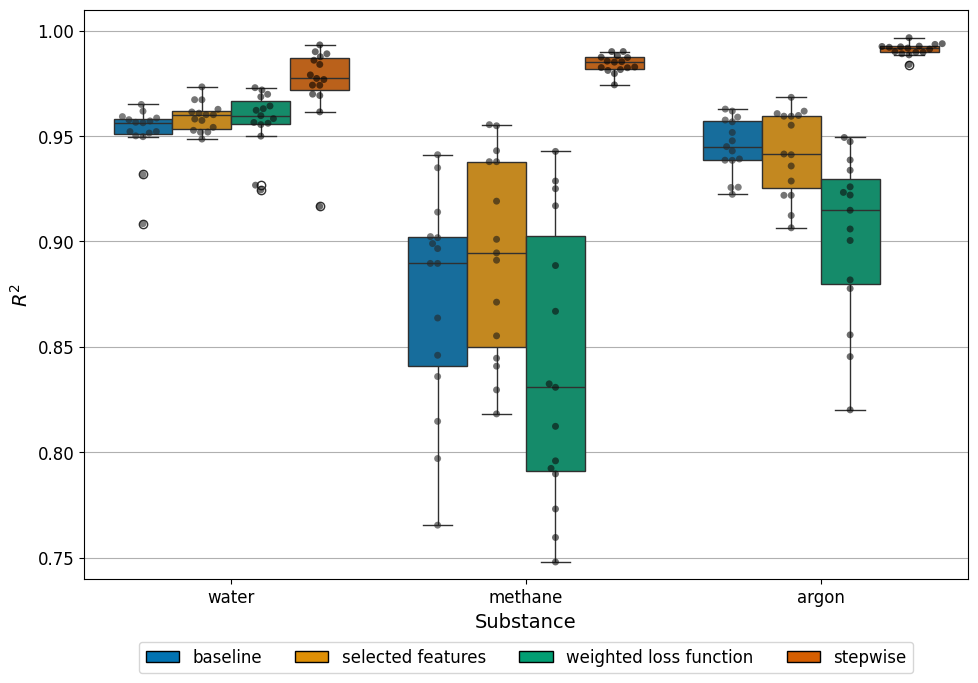

In [12]:
colors = sns.color_palette("colorblind", 8)
# Define hatches for each substance
df = R2_s
# Create the boxplot with Seaborn
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=df, x="Substance", y="Value", hue="Dataset", palette=colors)
ax = sns.swarmplot(data=df, x="Substance", y="Value", hue="Dataset", 
                   color='black', alpha=0.6, dodge=True)
color_legend = [Patch(facecolor=color, edgecolor='black', label=label)
                for label, color in zip(titles, colors)]
# put the legend outside the plot, on the right side of the plot
plt.legend(handles=color_legend, loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=4)
plt.xlabel("Substance")
plt.ylabel(f"$R^2$")
plt.ylim(0.74, 1.01)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig(f'{base_path}/result_pysr/R2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

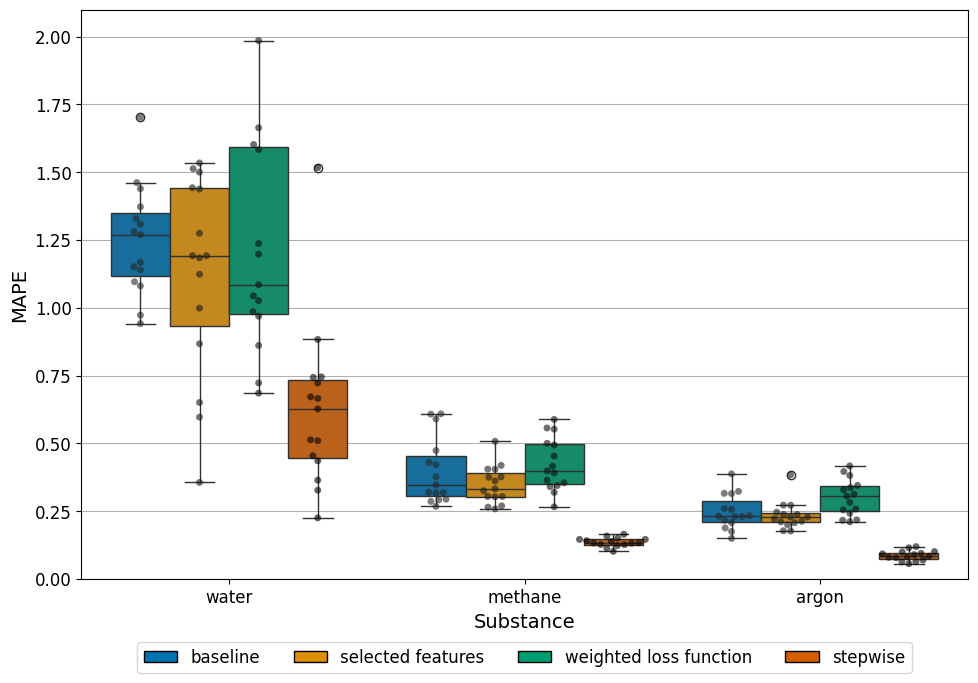

In [13]:
colors = sns.color_palette("colorblind", 6)
# Define hatches for each substance
df = MAPE_s
# Create the boxplot with Seaborn
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=df, x="Substance", y="Value", hue="Dataset", palette=colors)
ax = sns.swarmplot(data=df, x="Substance", y="Value", hue="Dataset", 
                   color='black', alpha=0.6, dodge=True)
color_legend = [Patch(facecolor=color, edgecolor='black', label=label)
                for label, color in zip(titles, colors)]
# put the legend outside the plot, on the right side of the plot
plt.legend(handles=color_legend, loc='lower center', bbox_to_anchor=(0.5, -0.18), ncol=4)
plt.ylim(0, 2.1)
plt.grid(axis='y')
plt.xlabel("Substance")
plt.ylabel(f"MAPE")
# plot y=36.395, y=23.725
#plt.axhline(y=0.36395, color='r', linestyle='--')
#plt.axhline(y=0.23725, color='b', linestyle='--')
plt.tight_layout()
plt.savefig(f'{base_path}/result_pysr/MSE_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
statistics = pd.DataFrame()
# calculate the mean and std of R2, MSE, MAPE for each substance in each dataset
for i in range(len(titles)):
    R2 = R2SS[i].drop('Dataset', axis=1)
    MSE = MSESS[i].drop('Dataset', axis=1)
    MAPE = MAPESS[i].drop('Dataset', axis=1)
    statistics.loc[titles[i], 'R2_mean'] = R2.mean().mean()
    statistics.loc[titles[i], 'R2_std'] = R2.mean().std()
    statistics.loc[titles[i], 'MSE_mean'] = MSE.mean().mean()
    statistics.loc[titles[i], 'MSE_std'] = MSE.mean().std()
    statistics.loc[titles[i], 'MAPE_mean'] = MAPE.mean().mean()
    statistics.loc[titles[i], 'MAPE_std'] = MAPE.mean().std()
print(statistics)

                         R2_mean    R2_std  MSE_mean   MSE_std  MAPE_mean  \
baseline                0.923005  0.043592  0.000105  0.000101   0.630522   
selected features       0.931481  0.034396  0.000090  0.000082   0.568429   
weighted loss function  0.900121  0.058590  0.000109  0.000074   0.666974   
stepwise                0.983527  0.007990  0.000042  0.000061   0.282575   

                        MAPE_std  
baseline                0.539497  
selected features       0.484684  
weighted loss function  0.533101  
stepwise                0.299244  


In [15]:
statistics = statistics.round(4)
# delete columns MSE_mean and MSE_std
statistics = statistics.drop(columns=['MSE_mean', 'MSE_std'])
statistics.to_excel(f'{base_path}/result_pysr/statistics.xlsx', index=True)

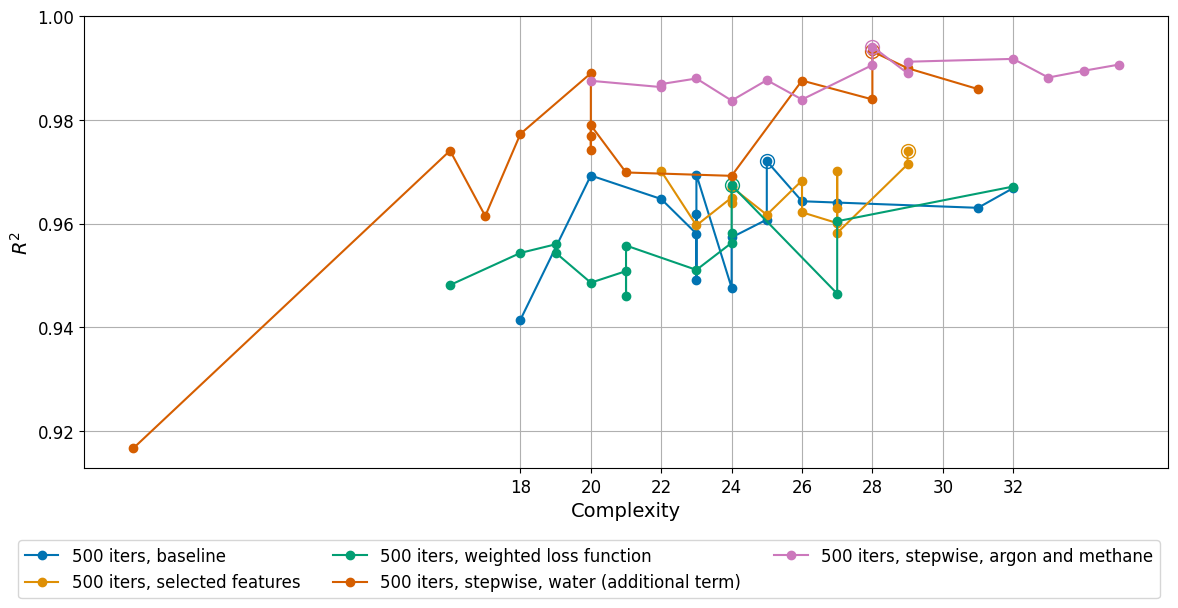

In [73]:
R2S = [R2_mn, R2_mfn, R2_mnw, R2_w, R2_a]
COMPLEXITIES = [COMPLEXITY_mn, COMPLEXITY_mfn, COMPLEXITY_mnw, COMPLEXITY_w, COMPLEXITY_a]
Y_PREDs = [Y_PRED_mn, Y_PRED_mfn, Y_PRED_mnw, Y_PRED_w, Y_PRED_a]
titles = ['baseline',
          'selected features',
          'weighted loss function',
          'stepwise, water (additional term)',
            'stepwise, argon and methane']

COLORS = sns.color_palette("colorblind", 6)

fig = plt.figure(figsize=(12, 6))
ax2 = fig.add_subplot(1, 1, 1)
for i in range(len(R2S)):
    data = {'R2': R2S[i], 'Complexity': COMPLEXITIES[i]}
    df = pd.DataFrame(data).sort_values(by='Complexity').reset_index(drop=True)
    ax2.plot(df['Complexity'], df['R2'], 'o-', color=COLORS[i], label=f'500 iters, {titles[i]}')
    max_r2 = df['R2'].max()
    max_complexity = df['Complexity'][df['R2'].idxmax()]
    ax2.plot(max_complexity, max_r2, 'o', color=COLORS[i], markersize=10, markerfacecolor='none')
ax2.set_xlabel('Complexity')
ax2.set_ylabel('$R^2$')
ax2.set_xticks(np.arange(min(min(COMPLEXITIES)), max(max(COMPLEXITIES)) + 2, 2))
ax2.set_yticks(np.arange(round(min(min(R2S)) - 0.02, 2), round(max(max(R2S)) + 0.02, 2), 0.02))
ax2.grid()

handles, labels = ax2.get_legend_handles_labels()  # Get handles and labels from the pareto plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.03), ncol=3, shadow=False)

# Adjust layout to fit legends and color bars
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom to make space for the legend
plt.savefig(f'{base_path}/result_pysr/pareto.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:
def reg_plot(y_origin, y_pred):
    # using sns.regplot to plot the regression plot
    sns.regplot(x=y_origin, y=y_pred, color='#955251',
                line_kws={'color': 'slategray', 'linestyle': '--'})
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    ymax = data_2['delta_phi'].max() + 0.05
    ymin = data_2['delta_phi'].min() - 0.05
    r2 = r2_score(y_origin, y_pred)
    MAPE = error_percentage(y_origin, y_pred)
    plt.text(0.1, 0.9, f'$R^2$ = {r2:.3f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'MAPE = {MAPE:.3f}%', transform=plt.gca().transAxes)
    # plot y=x line
    plt.plot([ymin, ymax], [ymin, ymax], color='slategray', linestyle='--')
    plt.ylim(ymin, ymax)
    
def plot_predict(model, data):
    X = data.drop('delta_phi', axis=1)
    y = model.predict(X)
    #y, equation = y_calculation(model, data)
    ymax = max(y.max(), data['delta_phi'].max()) + 0.05
    ymin = min(y.min(), data['delta_phi'].min()) - 0.05
    plt.figure(figsize=(12, 10))

    unique_mw = data['nu'].unique()
    unique_mw.sort()
    for i in range(0, min(3, len(unique_mw))):  # Loop through molecular weights
        data_part = data[data['nu'] == unique_mw[i-1]]
        y_part, equation = y_calculation(model, data_part)

        plt.subplot(3, 3, i*3  + 1)
        reg_plot(data_part['delta_phi'], y_part)

        plt.subplot(3, 3, i*3 + 2)
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(3, 3, i*3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted $\\Delta \\phi$')
    plt.tight_layout()
    plt.savefig('result_pysr/plot_predict.png', dpi=300, bbox_inches='tight')
    plt.show()

In [49]:
def plot_stepwise(model_1, model_2):
    X = data_1.drop('delta_phi', axis=1)
    y = model_1.predict(X)
    X_2 = data_2.drop('delta_phi', axis=1)
    y_2 = model_1.predict(X_2)-model_2.predict(X_2)
    ymax = max(y_2.max(), data_2['delta_phi'].max()) + 0.05
    ymin = min(y_2.min(), data_2['delta_phi'].min()) - 0.05
    #y, equation = y_calculation(model, data)
    plt.figure(figsize=(12, 10))
    plt.subplot(3, 3, 1)
    reg_plot(data_2['delta_phi'], y_2)
    plt.ylim(ymin, ymax)
    plt.xlim(ymin, ymax)
    plt.subplot(3, 3, 2)
    
    scatter = plt.scatter(data_2['density'], data_2['delta_phi'], c=data_2['temperature'], cmap='coolwarm')
    color_bar = plt.colorbar(scatter)
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('True $\\Delta \\phi$')
    plt.subplot(3, 3, 3)
    scatter = plt.scatter(data_2['density'], y_2, c=data_2['temperature'], cmap='coolwarm')
    color_bar = plt.colorbar(scatter)
    color_bar.set_label('Temperature')
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('Predicted $\\Delta \\phi$')

    unique_mw = data_1['nu'].unique()
    unique_mw.sort()
    for i in range(1, min(4, len(unique_mw)+1)):  # Loop through molecular weights
        data_part = data_1[data_1['nu'] == unique_mw[i-1]]
        y_part, equation = y_calculation(model_1, data_part)

        plt.subplot(3, 3, i*3  + 1)
        reg_plot(data_part['delta_phi'], y_part)
        plt.ylim(ymin, ymax)
        plt.xlim(ymin, ymax)
        plt.subplot(3, 3, i*3 + 2)
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='coolwarm')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(3, 3, i*3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='coolwarm')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted $\\Delta \\phi$')
    plt.tight_layout()
    plt.savefig('result_pysr/plot_predict_stepwise.png', dpi=300, bbox_inches='tight')
    plt.show()

Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_9_a_iter500_0411.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_9_a_iter500_0411.pkl
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_9_w_iter500_0450.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_9_w_iter500_0450.pkl


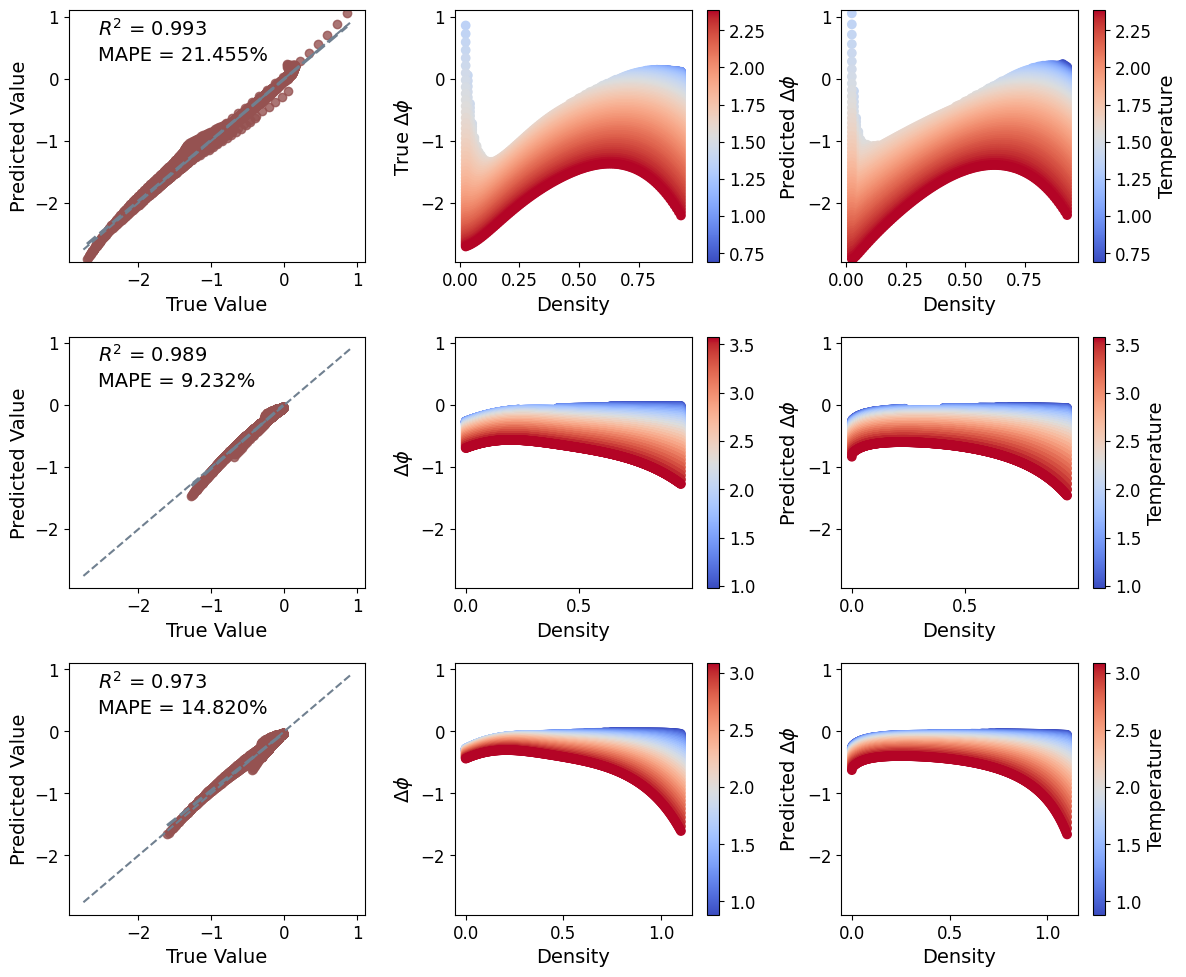

In [22]:
n = '9'
am = f'pySR_all_add_features_manual_normalized_n_{n}_a_iter500'
water = f'pySR_all_add_features_manual_normalized_n_{n}_w_iter500'
files = os.listdir(f"{base_path}/result_pysr")
file_name_am= [f for f in files if am in f and '.pkl' in f][0]
file_name_w= [f for f in files if water in f and '.pkl' in f][0]
data_am = data_1
data_w = data_2
model = PySRRegressor.from_file(f'{base_path}/result_pysr/{file_name_am}')
model_w = PySRRegressor.from_file(f'{base_path}/result_pysr/{file_name_w}')
plot_stepwise(model, model_w)

Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1521.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1521.pkl


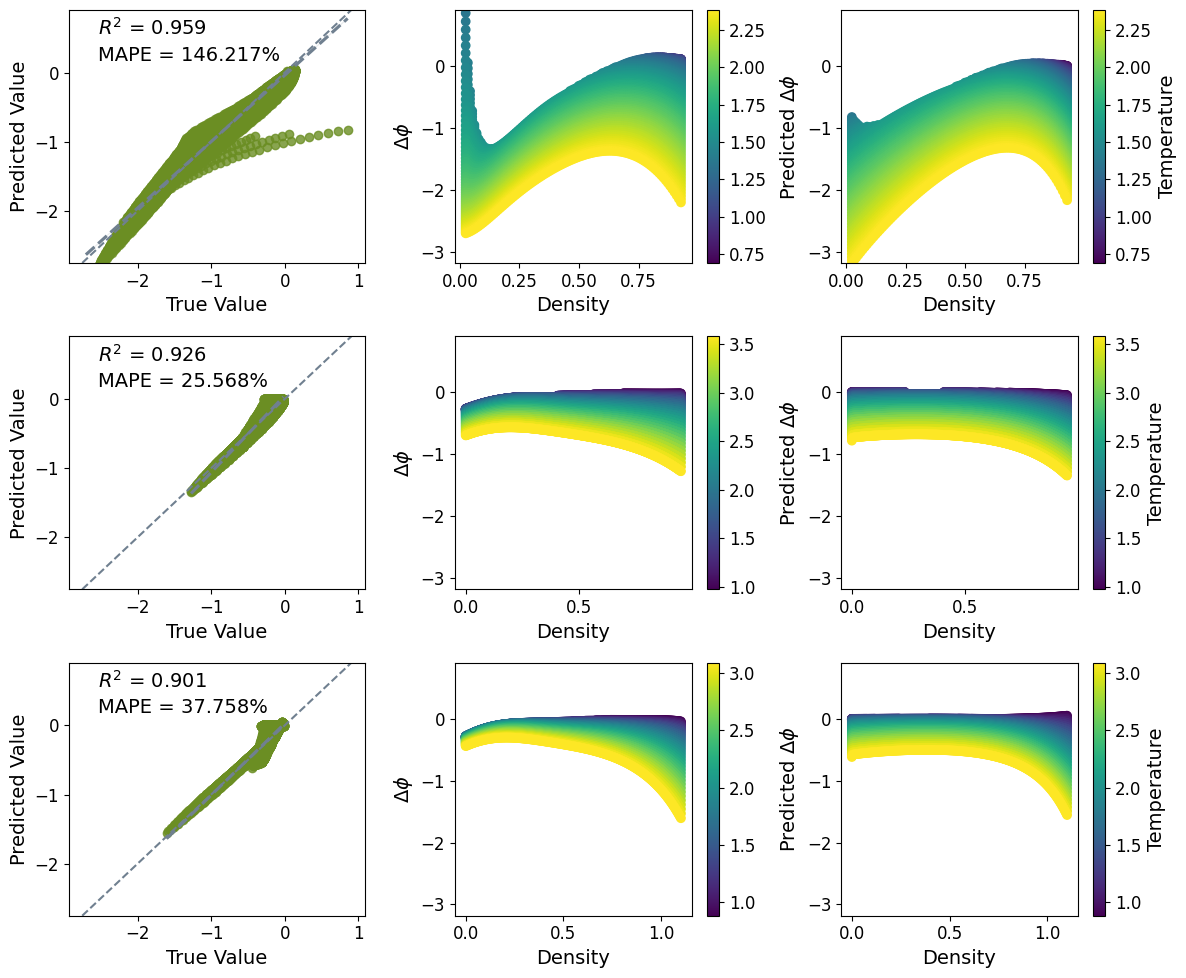

In [42]:
file_name = 'pySR_all_add_features_manual_normalized_n_iter500_1521'
# 2142 2153
data_p = data_n
model = PySRRegressor.from_file(f'{base_path}/result_pysr/{file_name}.pkl')
plot_predict(model, data_p)

In [24]:
equation = model.sympy()
# simplify the equation
equation = sp.simplify(equation)
variables = list(equation.free_symbols)  # Get symbols from the equation
print("Variables:", variables)

Variables: [temperature, density]


In [25]:
latex_equation = model.latex()  # Print the equation in LaTeX format
# replace \\ in latex_equation with \
latex_equation = latex_equation.replace('\\\\', '\\')
# replace temperature with T, density with \\rho, delta_phi with \\Delta \\phi
latex_equation = latex_equation.replace('temperature', 'T')
latex_equation = latex_equation.replace('density', '\\rho')
latex_equation = latex_equation.replace('delta_phi', '\\Delta \\phi')
latex_equation = latex_equation.replace('\\Sigma', '\\sigma')
print("Equation (LaTeX):", latex_equation)

Equation (LaTeX): - 0.0376 \left(T^{3} - \log{\left(\rho + 0.0713 \right)}^{3}\right) e^{- \sinh{\left(\cos{\left(\tan{\left(\rho \right)} \right)} \right)}} - 0.0182


In [45]:
equation_2 = model_w.sympy()
# simplify the equation
equation_2 = sp.simplify(equation_2)
variables_2 = list(equation_2.free_symbols)  # Get symbols from the equation
print("Variables:", variables_2)

Variables: [density, temperature]


In [46]:
model_w.latex()

'\\sqrt{temperature} \\left(temperature - \\sin{\\left(density temperature \\right)} - 0.644\\right) + \\left(density^{3} - 0.230\\right)^{2} - \\frac{0.00784}{density^{2} temperature^{6}}'

In [47]:
equation

0.34870714*(Epsilon + Kappa_AB)*(Sigma**3 - temperature)*(Sigma**2*(temperature - 1.37244922983648) + 1.48299080751721*(Epsilon*Sigma - tan(density))**2)/Sigma**2

In [14]:
SUBSTANCES = os.listdir(f'{base_path}/result_pysr')
SUBSTANCES = [substance.split('.')[0] for substance in SUBSTANCES if substance.endswith('.pkl')]
SUBSTANCES = [substance for substance in SUBSTANCES if 'manual_normalized_n_iter' in substance]
print(f"Total {len(SUBSTANCES)} files \n", SUBSTANCES)

# DataFrame to store feature importances
importance_table = pd.DataFrame()

for iter, substance in enumerate(SUBSTANCES):
    print(f"Processing model: {substance}")
    # Load model
    model = PySRRegressor.from_file(f'{base_path}/result_pysr/{substance}.pkl')
    equation = model.sympy()
    
    # Simplify the equation
    equation = sp.simplify(equation)
    variables = list(equation.free_symbols)  # Get symbols from the equation
    print("Variables:", variables)
    
    # Define variable ranges from data
    ranges = {var: (min(data_n[str(var)]), max(data_n[str(var)])) for var in variables}
    num_samples = 5
    
    # Generate sample points
    sample_points = {
        var: np.linspace(ranges[var][0], ranges[var][1], num_samples)
        for var in ranges
    }
    
    # Create a meshgrid of all variable combinations
    mesh = np.meshgrid(*sample_points.values(), indexing='ij')
    sample_combinations = {var: grid.ravel() for var, grid in zip(ranges.keys(), mesh)}
    
    # Calculate average importance for each variable
    variable_importance = {}
    for var in variables:
        partial_derivative = sp.diff(equation, var)  # Compute partial derivative
        slopes = []
        for i in range(len(mesh[0].ravel())):
            # Create a dictionary of variable values at this point
            values = {v: sample_combinations[v][i] for v in ranges.keys()}
            # Evaluate the derivative and store its absolute value
            slope_value = abs(partial_derivative.evalf(subs=values))
            slopes.append(slope_value)
        # Average the slopes
        variable_importance[str(var)] = np.mean(slopes)
    
    # Normalize importance for comparison
    total_importance = sum(variable_importance.values())
    normalized_importance = {key: val / total_importance for key, val in variable_importance.items()}
    
    # Store in DataFrame
    importance_table = pd.concat([importance_table, pd.DataFrame(normalized_importance, index=[substance])]
    )


Total 10 files 
 ['pySR_all_add_features_manual_normalized_n_iter500_1353', 'pySR_w_all_add_features_manual_normalized_n_iter500_0029', 'pySR_all_add_features_manual_normalized_n_iter500_1315', 'pySR_all_add_features_manual_normalized_n_iter500_1340', 'pySR_w_all_add_features_manual_normalized_n_iter500_2330', 'pySR_w_all_add_features_manual_normalized_n_iter500_0016', 'pySR_all_add_features_manual_normalized_n_iter500_1405', 'pySR_w_all_add_features_manual_normalized_n_iter500_0056', 'pySR_all_add_features_manual_normalized_n_iter500_1328', 'pySR_w_all_add_features_manual_normalized_n_iter500_0003']
Processing model: pySR_all_add_features_manual_normalized_n_iter500_1353
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1353.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1353.pkl
Variables: [Sigma, temperature, density, Epsilon, Kappa_AB]
Processing model: py

In [50]:
from sympy import preorder_traversal
unary_operators = [
    "cos", "sin", "exp", "tan", "sqrt", "log",
    "square", "cube", "sinh", "cosh"
]

# List substances
SUBSTANCES = [os.path.splitext(f)[0] for f in os.listdir(f'{base_path}/result_pysr')
              if f.endswith('.pkl') and 'manual_normalized_n_iter' in f]
print(f"Total {len(SUBSTANCES)} files\n", SUBSTANCES)

# Initialize a list to store results
results = []

# Function to count operators in an equation
def count_operators(equation, operators):
    operator_count = {op: 0 for op in operators}
    for node in preorder_traversal(equation):
        if hasattr(node, 'func') and node.func.__name__ in operators:
            operator_count[node.func.__name__] += 1
    return operator_count

# Process each file
for substance in SUBSTANCES:
    print(f"Processing model: {substance}")
    try:
        # Load model
        model = PySRRegressor.from_file(f'{base_path}/result_pysr/{substance}.pkl')
        equation = sp.simplify(model.sympy())
        predicted_value = model.predict(data_n.drop(columns=['delta_phi']))
        R2 = r2_score(data_n['delta_phi'], predicted_value)
        # Count unary operators
        operator_count = count_operators(equation, unary_operators)
        operator_count["R2"] = R2
        results.append(operator_count)
    except Exception as e:
        print(f"Error processing {substance}: {e}")

# Convert results to DataFrame
Operator_table = pd.DataFrame(results, columns=["R2"] + unary_operators)


Total 10 files
 ['pySR_all_add_features_manual_normalized_n_iter500_1353', 'pySR_w_all_add_features_manual_normalized_n_iter500_0029', 'pySR_all_add_features_manual_normalized_n_iter500_1315', 'pySR_all_add_features_manual_normalized_n_iter500_1340', 'pySR_w_all_add_features_manual_normalized_n_iter500_2330', 'pySR_w_all_add_features_manual_normalized_n_iter500_0016', 'pySR_all_add_features_manual_normalized_n_iter500_1405', 'pySR_w_all_add_features_manual_normalized_n_iter500_0056', 'pySR_all_add_features_manual_normalized_n_iter500_1328', 'pySR_w_all_add_features_manual_normalized_n_iter500_0003']
Processing model: pySR_all_add_features_manual_normalized_n_iter500_1353
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1353.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_n_iter500_1353.pkl
Processing model: pySR_w_all_add_features_manual_normalized_n_iter500_0029
Checki

In [66]:
operators = Operator_table.columns[1:]
statistics = pd.DataFrame(index=operators, columns=['Average R2', 'Sum of Operator'])
Operator_table[operators] = Operator_table[operators].astype(float)
statistics['Average R2'] = [
    np.average(Operator_table['R2'], weights=Operator_table[op]) if Operator_table[op].sum() > 0 else 0
    for op in operators
]
statistics['Sum of Operator'] = Operator_table[operators].sum()
statistics = statistics.sort_values(by='Average R2', ascending=False)

<Figure size 1000x600 with 0 Axes>

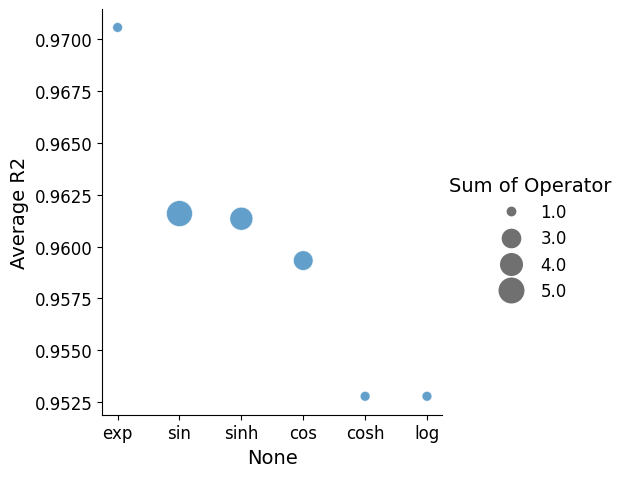

In [ ]:
# bubble plot
import seaborn as sns
statistics_filtered = statistics[statistics['Sum of Operator'] > 0]
plt.figure(figsize=(10, 6))
sns.relplot(data=statistics_filtered, x=statistics_filtered.index, y='Average R2',
            size='Sum of Operator', sizes=(50, 350), alpha=0.7, palette='viridis')
plt.show()

In [39]:
importance_long = importance_table.reset_index().melt(
    id_vars='index',  # Preserve model names if needed
    var_name='Feature',  # Column name for features
    value_name='Importance'  # Column name for importance values
)
importance_long['Importance'] = importance_long['Importance'].astype(float)

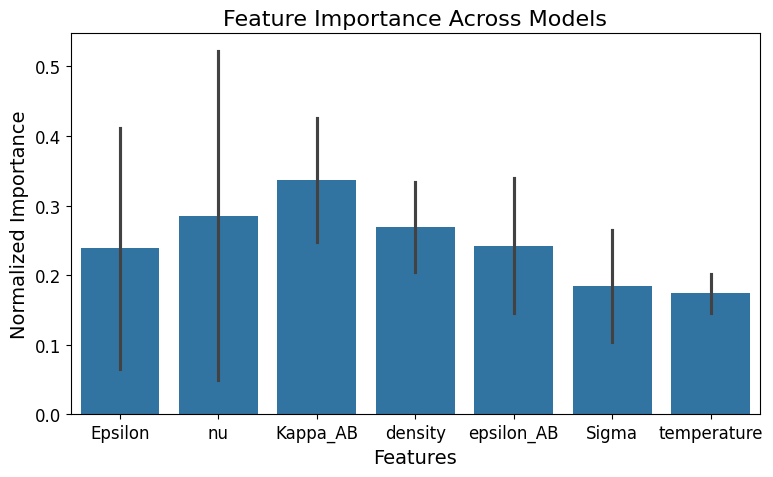

In [40]:
plt.figure(figsize=(8, 5))
#sns.boxplot(data=importance_long, x='Feature', y='Importance')
# plot barplot with error bars, from highest to lowest mean importance
importance_long = importance_long.sort_values('Importance', ascending=False)
sns.barplot(data=importance_long, x='Feature', y='Importance', ci='sd')
plt.title('Feature Importance Across Models', fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


In [65]:
variable_importance

{'Sigma': 0.395562759557948,
 'density': 2.16872940168509,
 'temperature': 1.06945836583256,
 'nu': 0.773147023085083,
 'Kappa_AB': 1.69715995106867}

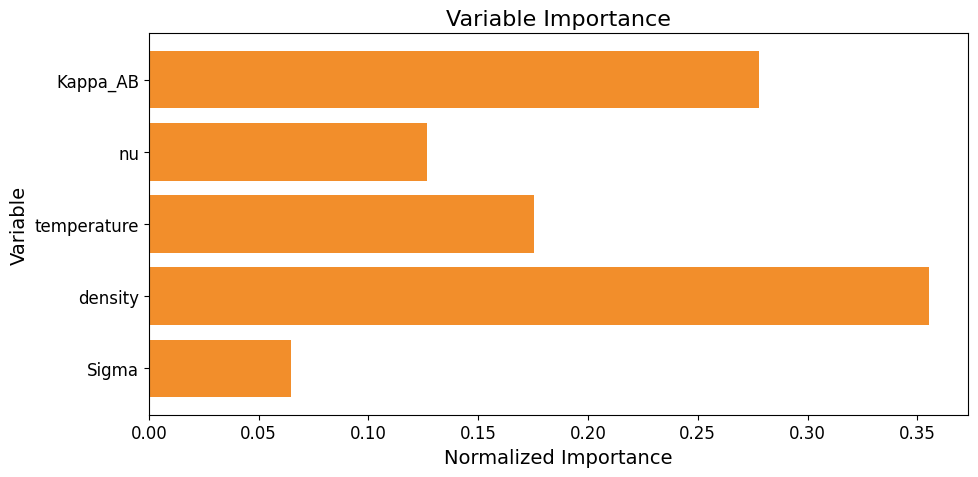

In [26]:
plt.figure(figsize=(10, 5))
plt.barh(list(normalized_importance.keys()), normalized_importance.values(), color='#F28E2B')
plt.xlabel("Normalized Importance")
plt.ylabel("Variable")
plt.title("Variable Importance")
plt.tight_layout()
plt.show()

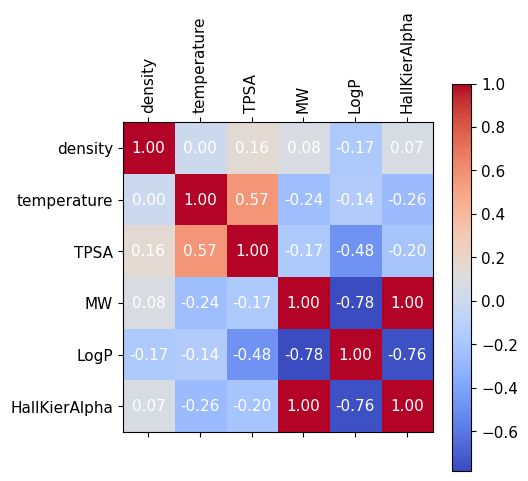

In [33]:
# calculate the person correlation coefficient of X
# plot the heatmap of the correlation matrix, show the correlation coefficient value in the heatmap
# fontsize
plt.rc('font', size=11)
corr = X.corr()
plt.figure(figsize=(5, 5))
plt.matshow(corr, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
plt.show()

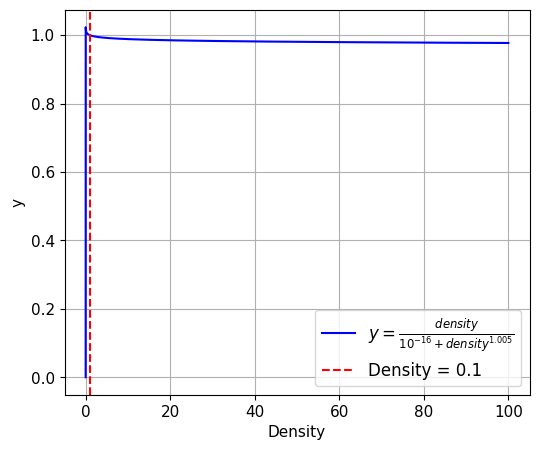

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the density range
density = np.linspace(0, 100, 10000)  # Generate values from 0 to 10

# Define the custom weight function
weights = density / (10**(-16) + density**1.005)

# Plot the function
plt.figure(figsize=(6, 5))
plt.plot(density, weights, label=r'$y = \frac{density}{10^{-16} + density^{1.005}}$', color='blue')
plt.xlabel('Density')
plt.ylabel('y')
# plot x = 0.1
plt.axvline(x=1, color='red', linestyle='--', label='Density = 0.1')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()



In [96]:
from sympy import symbols, limit, oo
density,temperature  = sp.symbols('density temperature')
new_eqaution = density*model.sympy()
res1=(new_eqaution).subs(density, 0)==0
restriction_2 = limit(equation, temperature, +oo).is_finite
print(res1,restriction_2)


True False


In [95]:
from sympy import diff
equation = model.sympy()
symbols_in_equation = equation.free_symbols
print("Symbols in the equation:", symbols_in_equation)
partials = {str(sym): diff(equation, sym) for sym in symbols_in_equation}
print("\nPartial derivatives:")
for sym, derivative in partials.items():
    print(f"∂/∂{sym}:", derivative)

Symbols in the equation: {temperature, density, MW}

Partial derivatives:
∂/∂temperature: -1.10244925641778e-8*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2
∂/∂density: -5.51224628208888e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2*sin(MW - 0.9328978)/sqrt(density)
∂/∂MW: -1.10244925641778e-8*sqrt(density)*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2*cos(MW - 0.9328978)


In [160]:
import pandas as pd
data_a = pd.read_csv('data/processed_data/all_add_features_filtered_normalized.csv')
data= pd.read_csv('data/processed_data/exclude_water.csv')
data_n = pd.read_csv('data/processed_data/exclude_add_features_normalized.csv')
data_n1 = pd.read_csv('data/processed_data/exclude_water_add_features_normalized.csv')
data_fn = pd.read_csv('data/processed_data/exclude_add_features_filtered_normalized.csv')
data_water = pd.read_csv('data/processed_data/water_add_features_normalized.csv')

In [ ]:
data_n.describe().loc[['min', 'max']]


,density,temperature,TPSA,MW,delta_phi
min,1.0,1.0,0.0,16.043,-1.607006
max,100.0,100.0,0.0,39.948,-0.015087


In [159]:
data_n1.describe().loc[['min', 'max']]

,density,temperature,TPSA,MW,delta_phi
min,1.0,1.0,0.0,16.043,-1.607006
max,100.0,100.0,0.0,39.948,-0.015087


In [4]:
from sympy import symbols, limit, oo
x = symbols('x')
limit_value = limit('sin(x)', x, oo).is_finite
print(limit_value)

True


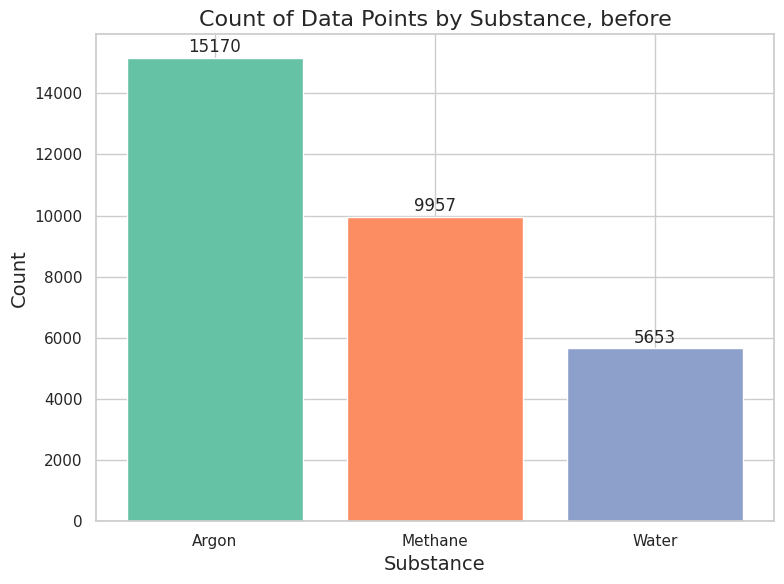

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming `data_n['nu']` contains the data to count
unique, counts = np.unique(data_n['nu'], return_counts=True)

# Define the substances (must match the unique values in `data_n['nu']`)
substances = ['Argon', 'Methane', 'Water']  # Capitalized for readability

# Ensure counts align correctly (sorting if necessary)
if len(counts) != len(substances):
    raise ValueError("Mismatch between substances and counts. Check data alignment.")

# Plotting
sns.set(style="whitegrid")  # Apply seaborn styling
plt.figure(figsize=(8, 6))

# Bar chart with defined color palette
colors = sns.color_palette("Set2")[:len(substances)]
plt.bar(substances, counts, color=colors)

# Add axis labels and a title
plt.xlabel('Substance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Data Points by Substance, before', fontsize=16)
# Add value annotations
for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=12)

# Display plot
plt.tight_layout()
plt.show()
